In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
%matplotlib inline

In [2]:
df = pd.read_csv("/blue/uf-iccc/chintan.acharya/Data/Colors.csv")
df.head()

,Unnamed: 0,Name,Color1,Color2,Color3,Color4,Color5
0,0,0001.jpg,"(148, 160, 158)","(255, 255, 255)","(118, 135, 80)","(148, 160, 158)","(255, 255, 255)"
1,1,0002.jpg,"(85, 101, 52)","(209, 215, 213)","(11, 10, 8)","(85, 101, 52)","(209, 215, 213)"
2,2,0003.jpg,"(175, 166, 157)","(107, 122, 163)","(10, 7, 34)","(175, 166, 157)","(107, 122, 163)"
3,3,0004.jpg,"(166, 184, 170)","(37, 71, 72)","(255, 234, 177)","(166, 184, 170)","(37, 71, 72)"
4,4,0005.jpg,"(52, 75, 117)","(158, 182, 220)","(2, 71, 52)","(52, 75, 117)","(158, 182, 220)"


In [3]:
image_data = []
label_data = []
count = 0
for index, row in df.iterrows():
    image_data.append((cv2.imread(os.path.join("/blue/uf-iccc/chintan.acharya/Data/resizedData", row['Name'])) / 127.5) - 1)
    labels = list(eval(row['Color1'])
                  + eval(row['Color2'])
                  + eval(row['Color3'])
                  + eval(row['Color4'])
                  + eval(row['Color5']))
    
    
    labels.append(random.randint(0, 255))
    
    label_data.append(np.array(labels))
    count += 1
    if(count == 2000):
        break
    

image_data = np.array(image_data)
label_data = np.array(label_data)
image_data.shape, label_data.shape

((2000, 512, 768, 3), (2000, 16))

In [4]:
label_data = label_data / 255
label_data

array([[0.58039216, 0.62745098, 0.61960784, ..., 1.        , 1.        ,
        0.11764706],
       [0.33333333, 0.39607843, 0.20392157, ..., 0.84313725, 0.83529412,
        0.47843137],
       [0.68627451, 0.65098039, 0.61568627, ..., 0.47843137, 0.63921569,
        0.25098039],
       ...,
       [0.24705882, 0.35294118, 0.56862745, ..., 0.34117647, 0.32941176,
        0.18823529],
       [0.        , 0.20392157, 0.38823529, ..., 0.51764706, 0.67843137,
        0.        ],
       [0.12941176, 0.14509804, 0.04705882, ..., 0.7254902 , 0.70588235,
        0.47058824]])

In [5]:

# label input
col_label = layers.Input(shape=(16,))
 
# latent vector input
latent_vector = layers.Input(shape=(200,))


In [6]:
def label_conditioned_generator(embedding_dim=100):
    label_dense = layers.Dense(32)(col_label)
    # reshape to additional channel
    label_reshape_layer = layers.Reshape((4, 4, 2))(label_dense)
    return label_reshape_layer
 
def latent_input(latent_dim=200):
    # image generator input
    nodes = 512 * 4 * 4
    latent_dense = layers.Dense(nodes)(latent_vector)
    latent_dense = layers.ReLU()(latent_dense)
    latent_reshape = layers.Reshape((4, 4, 512))(latent_dense)
    return latent_reshape

In [7]:
def define_generator():
    latent_vector_output = label_conditioned_generator()
    label_output = latent_input()
    merge = layers.Concatenate()([latent_vector_output, label_output])
     
    x = layers.Conv2DTranspose(128 * 8, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1')(merge)
    
    
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.ReLU(name='relu_1')(x)
     
    x = layers.Conv2DTranspose(128 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.ReLU(name='relu_2')(x)
     
    x = layers.Conv2DTranspose(128 * 2, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3')(x)
    x = layers.ReLU(name='relu_3')(x)
   
 
    x = layers.Conv2DTranspose(128 * 1, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.ReLU(name='relu_4')(x) 
    
    x = layers.Conv2DTranspose(64, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_5')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_5')(x)
    x = layers.ReLU(name='relu_5')(x)
    
    x = layers.Conv2DTranspose(16, 4, (2, 3), padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_6')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_6')(x)
    x = layers.ReLU(name='relu_6')(x)
     
     
    out_layer = layers.Conv2DTranspose(3, 2, (2, 2) ,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, activation='tanh', name='conv_transpose_7')(x)
     
     
   # define model
    model = tf.keras.Model([latent_vector, col_label], out_layer)
    return model



In [8]:
conditional_gen = define_generator()
conditional_gen.summary()

2023-01-29 04:11:36.822573: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 04:11:37.366196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 8192)         1646592     ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 32)           544         ['input_1[0][0]']                
                                                                                              

In [9]:
col_label = layers.Input(shape=(16,))
 
# input image
inp_img = layers.Input(shape=(512,768,3))

In [10]:
def label_condition_disc(in_shape=(512,768,3), embedding_dim=100):
    # embedding for categorical input
    nodes = in_shape[0] * in_shape[1] * in_shape[2]
    # scale up to image dimensions with linear layer
    label_dense = layers.Dense(nodes)(col_label)
    # reshape to a tensor
    label_reshape_layer = layers.Reshape((in_shape[0], in_shape[1], 3))(label_dense)
    # image input
    return label_reshape_layer
 
 
def image_disc(in_shape=(512,768,3)):
    return inp_img

In [11]:
def define_discriminator():
    label_condition_output = label_condition_disc()
    inp_image_output = image_disc()
    # concat label as a channel
    merge = layers.Concatenate()([inp_image_output, label_condition_output])
     
    x = layers.Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_1')(merge)
    x = layers.LeakyReLU(0.2, name='leaky_relu_1')(x)
     
    x = layers.Conv2D(64 * 2, kernel_size=4, strides= 3, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_2')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_2')(x)
     
    x = layers.Conv2D(64 * 4, 4, 3, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_3')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_3')(x)
       
    x = layers.Conv2D(64 * 8, 4, 3,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(
    mean=0.0, stddev=0.02), use_bias=False, name='conv_5')(x)
    x = layers.BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_4')(x)
    x = layers.LeakyReLU(0.2, name='leaky_relu_5')(x)
   
  
    flattened_out = layers.Flatten()(x)
    # dropout
    dropout = layers.Dropout(0.4)(flattened_out)
    # output
    dense_out = layers.Dense(1, activation='sigmoid')(dropout)
    # define model
 
 
    # define model
    model = tf.keras.Model([inp_image_output, col_label], dense_out)
    return model

In [12]:
conditional_discriminator = define_discriminator()
conditional_discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 1179648)      20054016    ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 512, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 reshape_2 (Reshape)            (None, 512, 768, 3)  0           ['dense_2[0][0]']          

In [13]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [14]:
def generator_loss(label, fake_output):
    gen_loss = binary_cross_entropy(label, fake_output)
    #print(gen_loss)
    return gen_loss

In [15]:
def discriminator_loss(label, output):
    disc_loss = binary_cross_entropy(label, output)
    #print(total_loss)
    return disc_loss

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
conditional_gen.compile(optimizer = generator_optimizer, loss = binary_cross_entropy)
conditional_discriminator.compile(optimizer = discriminator_optimizer, loss = binary_cross_entropy)                       

In [18]:
latent_dim=200
disc_losses1 = []
disc_losses2 = []
gen_losses = []

In [19]:
tf.config.run_functions_eagerly(False)

In [20]:
@tf.function
def train_step(images,target):
    # noise vector sampled from normal distribution
    noise = tf.random.normal([target.shape[0], latent_dim])
    # Train Discriminator with real labels
    with tf.GradientTape() as disc_tape1:
        generated_images = conditional_gen([noise,target], training=True)
 
         
        real_output = conditional_discriminator([images,target], training=True)
        real_targets = tf.ones_like(real_output)
        disc_loss1 = discriminator_loss(real_targets, real_output)
        disc_losses1.append(disc_loss1)
         
    # gradient calculation for discriminator for real labels    
    gradients_of_disc1 = disc_tape1.gradient(disc_loss1, conditional_discriminator.trainable_variables)
     
    # parameters optimization for discriminator for real labels   
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc1,\
    conditional_discriminator.trainable_variables))
     
    # Train Discriminator with fake labels
    with tf.GradientTape() as disc_tape2:
        fake_output = conditional_discriminator([generated_images,target], training=True)
        fake_targets = tf.zeros_like(fake_output)
        disc_loss2 = discriminator_loss(fake_targets, fake_output)
        disc_losses2.append(disc_loss2)
    # gradient calculation for discriminator for fake labels 
    gradients_of_disc2 = disc_tape2.gradient(disc_loss2, conditional_discriminator.trainable_variables)
     
     
    # parameters optimization for discriminator for fake labels        
    discriminator_optimizer.apply_gradients(zip(gradients_of_disc2,\
    conditional_discriminator.trainable_variables))
     
    # Train Generator with real labels
    with tf.GradientTape() as gen_tape:
        generated_images = conditional_gen([noise,target], training=True)
        fake_output = conditional_discriminator([generated_images,target], training=True)
        real_targets = tf.ones_like(fake_output)
        gen_loss = generator_loss(real_targets, fake_output)
        gen_losses.append(gen_loss)
 
    # gradient calculation for generator for real labels     
    gradients_of_gen = gen_tape.gradient(gen_loss, conditional_gen.trainable_variables)
     
    # parameters optimization for generator for real labels
    generator_optimizer.apply_gradients(zip(gradients_of_gen,\
    conditional_gen.trainable_variables))   


In [21]:
import time
def train(images, labels, epochs):
  for epoch in range(epochs):
    start = time.time()
    prev = 0
    for n in range(10, 2000, 10):
        image_batch = images[prev: n]
        target = labels[prev: n]
        prev = n
        img = tf.cast(image_batch, tf.float32)
        train_step(img,target)
    print("EPOCH", epoch + 1)
    print("----------------------------------------------------------------------------")
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    # print("Generator loss: ", gen_losses[-1].numpy(), end = "     ")
    # print("True Discriminator loss: ", disc_losses1[-1].numpy(), end="    ") 
    # print("Fake Discriminator loss: ", disc_losses2[-1].numpy())   
    print("----------------------------------------------------------------------------")
    print()

In [22]:
train(image_data, label_data, 1000)

2023-01-29 04:11:40.726368: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-29 04:11:41.354671: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-01-29 04:11:42.509074: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-01-29 04:11:42.747640: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


EPOCH 1
----------------------------------------------------------------------------
Time for epoch 1 is 18.100600957870483 sec
----------------------------------------------------------------------------

EPOCH 2
----------------------------------------------------------------------------
Time for epoch 2 is 12.594869136810303 sec
----------------------------------------------------------------------------

EPOCH 3
----------------------------------------------------------------------------
Time for epoch 3 is 12.651394844055176 sec
----------------------------------------------------------------------------

EPOCH 4
----------------------------------------------------------------------------
Time for epoch 4 is 12.629197597503662 sec
----------------------------------------------------------------------------

EPOCH 5
----------------------------------------------------------------------------
Time for epoch 5 is 12.621761798858643 sec
------------------------------------------------

In [23]:
conditional_gen.save("/blue/uf-iccc/chintan.acharya/LandScapeGanFinal2.h5")

In [24]:
import matplotlib.gridspec as gridspec
from PIL import Image
def generate_images(model, test_input, labels):

    # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    output = None
    for n in range(3):
        predictions = model([test_input, labels], training=False)
        if output is None:
            output = predictions
        else:
            output = np.concatenate((output,predictions))
    

    # plt.imshow(np.array(( output[0]+1 )*127.5, dtype = np.uint8))
 
    # im = Image.fromarray(np.array((output[0]+1) * 127.5, dtype =np.uint8))
    # im.save("your_file.jpeg")
      
    nrow = 3
    ncol = 10
    fig = plt.figure(figsize=(25,25))
    gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1, 1,1, 1,1, 1, 1, 1, 1],
         wspace=0.0, hspace=0.0, top=0.2, bottom=0.00, left=0.17, right=0.845)
    k = 0
    for i in range(nrow):
        for j in range(ncol):
            pred = (output[k, :, :, :] + 1) * 127.5
            pred = np.array(pred)  
            ax= plt.subplot(gs[i,j])
            ax.imshow(pred.astype(np.uint8))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.axis('off')
            k += 1  
 
    plt.show()

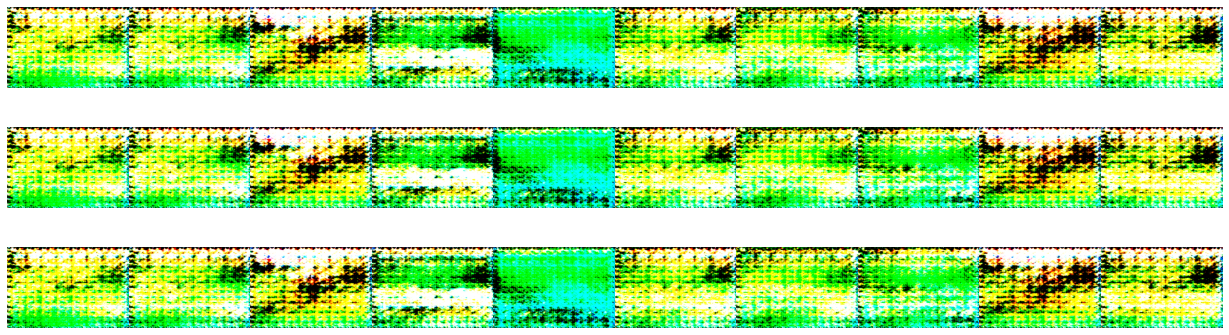

In [25]:
import random

num_examples_to_generate = 10
latent_dim = 200
n_classes = 3
noise = tf.random.normal([num_examples_to_generate, latent_dim])
labels = []
for i in range(10):
    label = []
    for j in range(15):
        label.append(random.randint(0, 255))
    label.append(255)
    labels.append(label)
generate_images(tf.keras.models.load_model("/blue/uf-iccc/chintan.acharya/LandScapeGanFinal2.h5"), noise,  np.array(labels))